# Credit Fraud Detection

## The objective is to create and compare models that will help us detect credit fraud, these models will be judged on accuracy, precision, recall and their f-1 score

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
import random
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

random.seed(42)



## Exploratory Data Analysis

In [2]:
df = pd.read_csv('creditcard.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.isna().sum().sum()

0

In [5]:
df_a = df.loc[:, ['Time', 'Amount', 'Class']]

In [6]:
df_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   Amount  284807 non-null  float64
 2   Class   284807 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 6.5 MB


In [7]:
df_a.describe()

,Time,Amount,Class
count,284807.000000,284807.000000,284807.000000
mean,94813.859575,88.349619,0.001727
std,47488.145955,250.120109,0.041527
min,0.000000,0.000000,0.000000
25%,54201.500000,5.600000,0.000000
50%,84692.000000,22.000000,0.000000
75%,139320.500000,77.165000,0.000000
max,172792.000000,25691.160000,1.000000


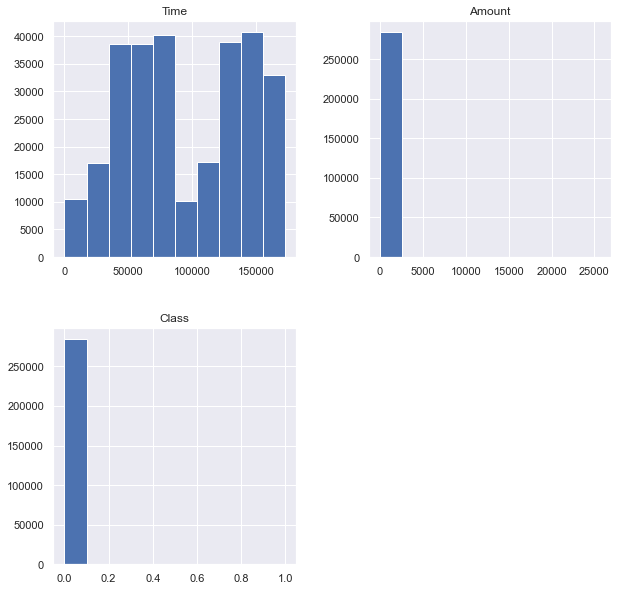

In [8]:
df_a.hist(figsize=(10,10));

### Handling Outliers

In [9]:
amount_99 = df.Amount.quantile(0.99)
df = df[df['Amount'] < amount_99]

In [10]:
df.Class.value_counts()

0    281475
1       483
Name: Class, dtype: int64

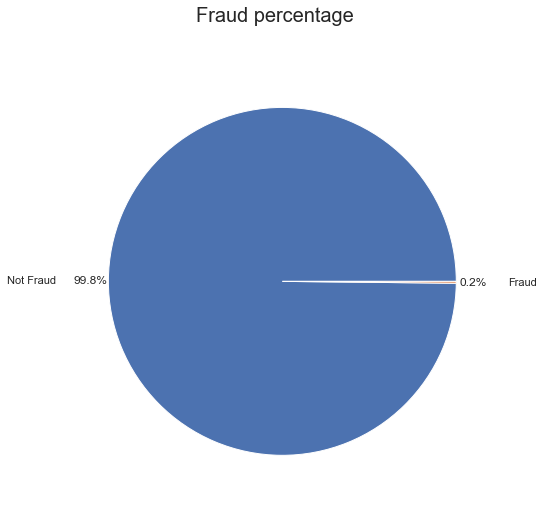

In [11]:
fraud = df_a.Class.value_counts()[0]
not_fraud = df_a.Class.value_counts()[1]

labels = ['Not Fraud' , 'Fraud']
sizes = [fraud, not_fraud]

plt.figure(figsize=(8,8))
plt.suptitle("Fraud percentage", fontsize= 20)
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow= False, labeldistance= 1.3, pctdistance= 1.1);

### Splitting the dataframe into test and train data

In [12]:

train_data, test_data = train_test_split(df, test_size= 0.25)

### Determining the features and result for the test data

In [13]:
fraud = test_data[test_data.Class == 1]
not_fraud = test_data[test_data.Class == 0]

### Downsampling the not_fraud in the test data to get a more reasonable value of accuracy
#### As fraud is is only 0.2% of the population therefore it's imbalanced and accuracy has problems with imbalanced classes 

In [14]:
downsampling_fraud = resample(not_fraud, replace=True, n_samples= len(fraud), random_state=42)

test_data = pd.concat([fraud, downsampling_fraud])

X_test = test_data.drop('Class', axis = 1)
y_test = test_data.Class

In [15]:
test_data.shape, X_test.shape, y_test.shape

((220, 31), (220, 30), (220,))

### Bootstrapping fraud training data for equal number of samples

In [16]:
fraud = train_data[train_data.Class == 1]
not_fraud = train_data[train_data.Class == 0]

upsampling_fraud = resample(fraud, replace=True, n_samples= len(not_fraud), random_state=42)
upsampled_data = pd.concat([not_fraud, upsampling_fraud])

upsampled_data.Class.value_counts()

0    211095
1    211095
Name: Class, dtype: int64

With so few positives relative to negatives, the training model will spend most of its time on negative examples and not learn enough from positive ones. Therefore we bootstrapped the data to make it balanced

### Determining the features and result for the train data

In [17]:
X_train = upsampled_data.drop('Class', axis = 1)
y_train = upsampled_data.Class

## Random Forest

In [18]:
rf = RandomForestClassifier(n_estimators = 40)
rf_model = rf.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print('Random Forest')
print("Accuracy :" + str(accuracy_score(y_test ,rf_pred)))
print("Recall :" + str(recall_score(y_test ,rf_pred)))
print("Precision :" + str(precision_score(y_test ,rf_pred)))
print("F1 :" + str(f1_score(y_test ,rf_pred)))

Random Forest
Accuracy :0.9136363636363637
Recall :0.8272727272727273
Precision :1.0
F1 :0.9054726368159205


### Determining which features are the most important

In [19]:
rf_model.feature_importances_

array([0.00420711, 0.01374618, 0.00707182, 0.07099943, 0.1050107 ,
       0.00745434, 0.00675889, 0.01176642, 0.00819241, 0.00791167,
       0.11177726, 0.12326992, 0.10434474, 0.00750736, 0.2365959 ,
       0.00651003, 0.03663249, 0.02495322, 0.00766066, 0.01209147,
       0.01168146, 0.00734362, 0.00589354, 0.00824222, 0.00524104,
       0.00565956, 0.00711263, 0.01537088, 0.00706802, 0.01192501])

## Logistic Regression

In [20]:
lr = LogisticRegression(max_iter= 500)
lr_model = lr.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
print('Logistic Regression')
print("Accuracy :" + str(accuracy_score(y_test ,lr_pred)))
print("Recall :" + str(recall_score(y_test ,lr_pred)))
print("Precision :" + str(precision_score(y_test ,lr_pred)))
print("F1 :" + str(f1_score(y_test ,lr_pred)))

Logistic Regression
Accuracy :0.9363636363636364
Recall :0.9
Precision :0.9705882352941176
F1 :0.9339622641509434


## Gaussian Naive Bayes

In [21]:
gnb = GaussianNB()
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
gnb = GridSearchCV(estimator=gnb, 
                 param_grid=params_NB, 
                 cv= cv,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy')

gnb_model = gnb.fit(X_train, y_train)
gnb_pred = gnb_model.predict(X_test)
print('Gaussian Naive Bayes')
print("Accuracy :" + str(accuracy_score(y_test ,gnb_pred)))
print("Recall :" + str(recall_score(y_test ,gnb_pred)))
print("Precision :" + str(precision_score(y_test ,gnb_pred)))
print("F1 :" + str(f1_score(y_test ,gnb_pred)))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Gaussian Naive Bayes
Accuracy :0.8545454545454545
Recall :0.7181818181818181
Precision :0.9875
F1 :0.8315789473684211


# Conclusion

#### The logistic regression has the best accuracy which makes sense as based on (50% fraud, 50% not fraud ) test set and the best recall, the Random Forest with 40 trees has a 1.0 precision  score which is a bit better than logistic regression,  the f-1 score is best for the logistic regression
### I personally think that accuracy after the downsampling of the not_fraud test data is the best metric to consider

### The best model to use between the above three models in the case of this dataset for fraud detection should be the Logistic Regression it provides overall the best results